In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights
from train_utils import train, predict
from diagnostic_tools import top_k_accuracy, per_class_accuracy,\
    count_params, entropy, model_calibration, show_errors, most_confused_classes,\
    most_inaccurate_k_classes
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 32

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=64, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

16980

# Model

In [6]:
from get_resnet18 import get_model

In [7]:
# w[j]: 1/number_of_samples_in_class_j
# decode: folder name to class name (in human readable format)
w, decode = get_class_weights(val_folder.class_to_idx)

In [8]:
model, criterion, optimizer = get_model(class_weights=torch.FloatTensor(w/w.sum()))

In [9]:
# number of params in the model
count_params(model)

11307840

# Train

In [10]:
n_epochs = 20
n_batches = ceil(train_size/batch_size)
# number of cycles
M = 1 
# total number of optimization steps
T = n_batches*n_epochs 
# initial learning rates
initial1 = 1e-2
initial2 = 1e-3
n_batches

531

In [11]:
# cyclical cosine annealing
# it changes the learning rate on every optimization step
# 1e-6 is the minimal learning rate
def lr_scheduler(optimizer, step):
    
    global initial1
    global initial2
    decay = np.cos(np.pi*((step - 1) % (T // M))/(T // M)) + 1.0
    
    # params of the last fc layer
    for param_group in optimizer.param_groups[:2]:
        param_group['lr'] = ((initial1 - 1e-6)*decay/2.0) + 1e-6
    
    # params of the last two resnet blocks
    for param_group in optimizer.param_groups[2:]:
        param_group['lr'] = ((initial2 - 1e-6)*decay/2.0) + 1e-6
    
    if (step - 1) % (T // M) == 0 and step != 1:
        print('lr is reset')
        
    return optimizer

In [12]:
%%time
all_losses, _ = train(
    model, criterion, optimizer, 
    train_iterator, n_epochs, n_batches, 
    val_iterator, validation_step=531, n_validation_batches=80, 
    saving_step=None, lr_scheduler=lr_scheduler
)
# epoch logloss    accuracy     top5_accuracy time  (first value: train, second value: val)

1.00  3.568 1.539  0.290 0.640  0.523 0.860  93.473
2.00  2.173 1.167  0.511 0.715  0.782 0.911  92.533
3.00  1.800 1.127  0.571 0.729  0.827 0.907  92.781
4.00  1.617 1.042  0.616 0.749  0.850 0.921  92.782
5.00  1.472 1.006  0.640 0.757  0.866 0.923  92.694
6.00  1.320 0.943  0.675 0.773  0.886 0.929  92.855
7.00  1.219 0.912  0.693 0.772  0.895 0.930  92.534
8.00  1.096 0.885  0.720 0.784  0.908 0.931  92.721
9.00  1.026 0.876  0.731 0.790  0.914 0.928  92.637
10.00  0.970 0.862  0.748 0.794  0.921 0.932  92.770
11.00  0.876 0.852  0.763 0.796  0.931 0.935  92.591
12.00  0.853 0.823  0.771 0.800  0.933 0.936  92.801
13.00  0.798 0.811  0.787 0.806  0.940 0.938  92.600
14.00  0.757 0.804  0.797 0.808  0.943 0.935  92.649
15.00  0.717 0.783  0.803 0.811  0.947 0.938  92.876
16.00  0.699 0.785  0.810 0.812  0.948 0.940  92.785
17.00  0.685 0.777  0.812 0.814  0.949 0.940  92.425
18.00  0.687 0.773  0.812 0.814  0.949 0.939  92.556
19.00  0.668 0.769  0.819 0.815  0.952 0.939  92.597
20

# Loss/epoch plots

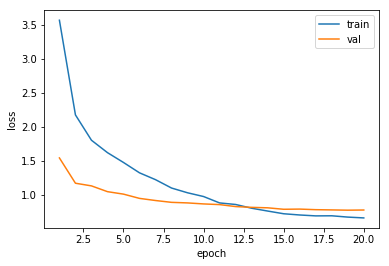

In [13]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

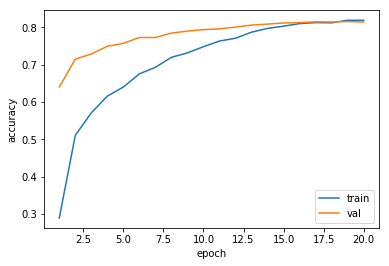

In [14]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

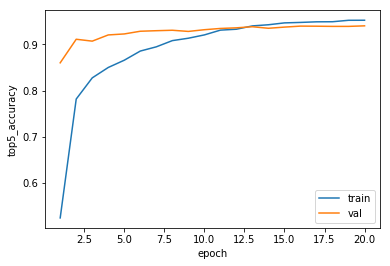

In [15]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Error analysis

### get human readable class names

In [16]:
# index to class name
decode = {val_folder.class_to_idx[k]: decode[int(k)] for k in val_folder.class_to_idx}

### get all predictions and all misclassified images 

In [17]:
val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=64, shuffle=False
)

In [18]:
val_predictions, val_true_targets,\
    erroneous_samples, erroneous_targets,\
    erroneous_predictions = predict(model, val_iterator_no_shuffle, return_erroneous=True)
# erroneous_samples: images that were misclassified
# erroneous_targets: their true labels
# erroneous_predictions: predictions for them

100%|██████████| 80/80 [00:19<00:00,  4.10it/s]


### number of misclassified images (there are overall 5120 images in the val dataset)

In [19]:
n_errors = len(erroneous_targets)
n_errors

953

### logloss and accuracies

In [20]:
log_loss(val_true_targets, val_predictions)

0.74747920063776951

In [21]:
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.81386718749999998

In [22]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.884765625, 0.91484374999999996, 0.92949218749999996, 0.9404296875, 0.96445312500000002]


### entropy of predictions

In [23]:
hits = val_predictions.argmax(1) == val_true_targets

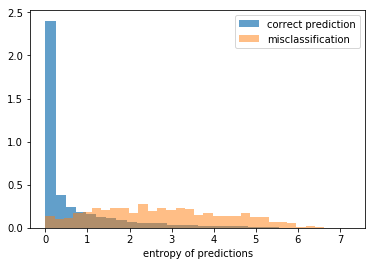

In [24]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('entropy of predictions');

### confidence of predictions

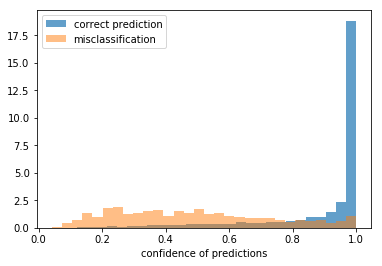

In [25]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

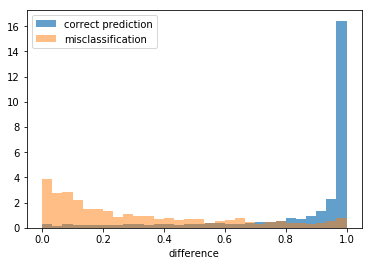

In [26]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('difference');

### probabilistic calibration of the model

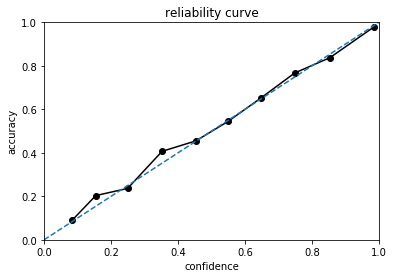

In [27]:
model_calibration(val_true_targets, val_predictions, n_bins=10)

### per class accuracies

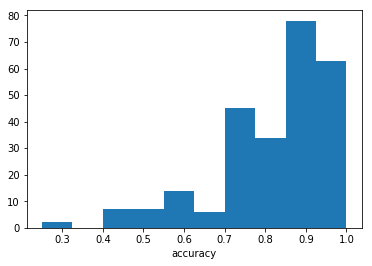

In [28]:
per_class_acc = per_class_accuracy(val_true_targets, val_predictions)
plt.hist(per_class_acc);
plt.xlabel('accuracy');

In [29]:
most_inaccurate_k_classes(per_class_acc, 15, decode)

drinking-straw 0.25
mailbox 0.3
playing-card 0.4
screwdriver 0.4
skateboard 0.4
sneaker 0.45
soda-can 0.45
frog 0.45
sword 0.45
duck 0.5
rifle 0.5
minotaur 0.5
frisbee 0.5
coffin 0.5
baseball-bat 0.5


### class accuracy vs. number of samples in the class

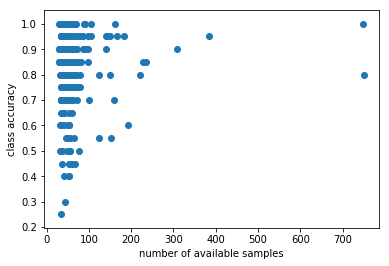

In [30]:
plt.scatter((1.0/w), per_class_acc);
plt.ylabel('class accuracy');
plt.xlabel('number of available samples');

### most confused pairs of classes

In [31]:
confused_pairs = most_confused_classes(
    val_true_targets, val_predictions, decode, min_n_confusions=4
)
confused_pairs

[('hibiscus', 'iris'),
 ('kayak', 'canoe'),
 ('knife', 'skateboard'),
 ('mandolin', 'electric-guitar'),
 ('mountain-bike', 'touring-bike'),
 ('people', 'cake'),
 ('pyramid', 'skyscraper'),
 ('screwdriver', 'syringe'),
 ('sneaker', 'tennis-shoes'),
 ('swan', 'goose'),
 ('breadmaker', 'washing-machine'),
 ('yo-yo', 'frisbee'),
 ('toad', 'frog'),
 ('comet', 'galaxy'),
 ('duck', 'goose')]

### show some low entropy errors

In [32]:
erroneous_entropy = entropy(erroneous_predictions)
mean_entropy = erroneous_entropy.mean()
low_entropy = mean_entropy < erroneous_entropy
mean_entropy

2.7421846564140728

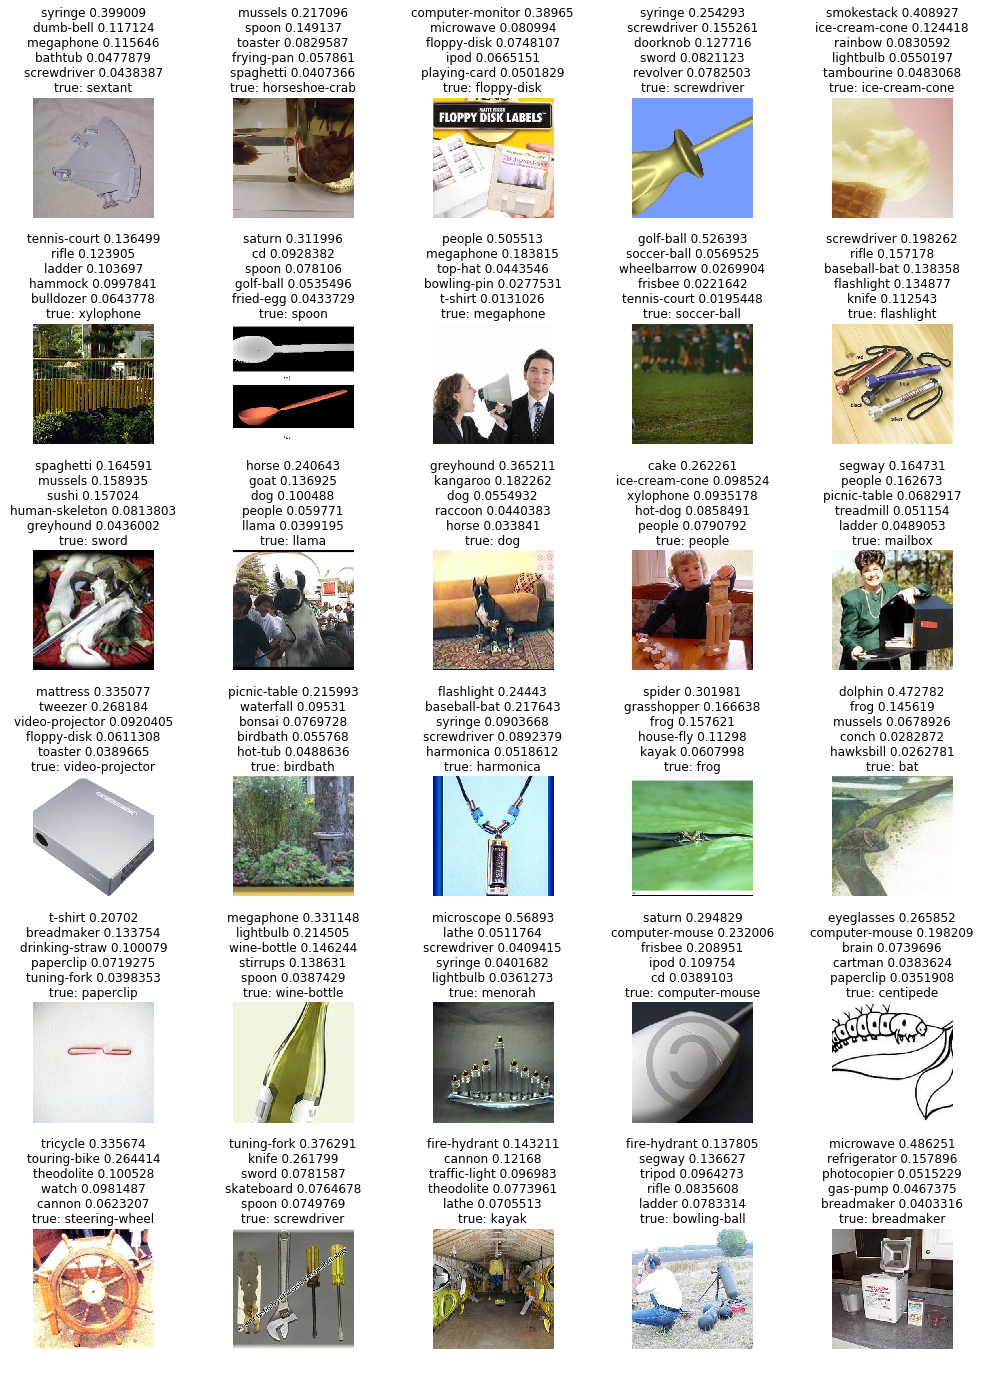

In [33]:
show_errors(
    erroneous_samples[low_entropy], 
    erroneous_predictions[low_entropy], 
    erroneous_targets[low_entropy], 
    decode
)

### show some high entropy errors

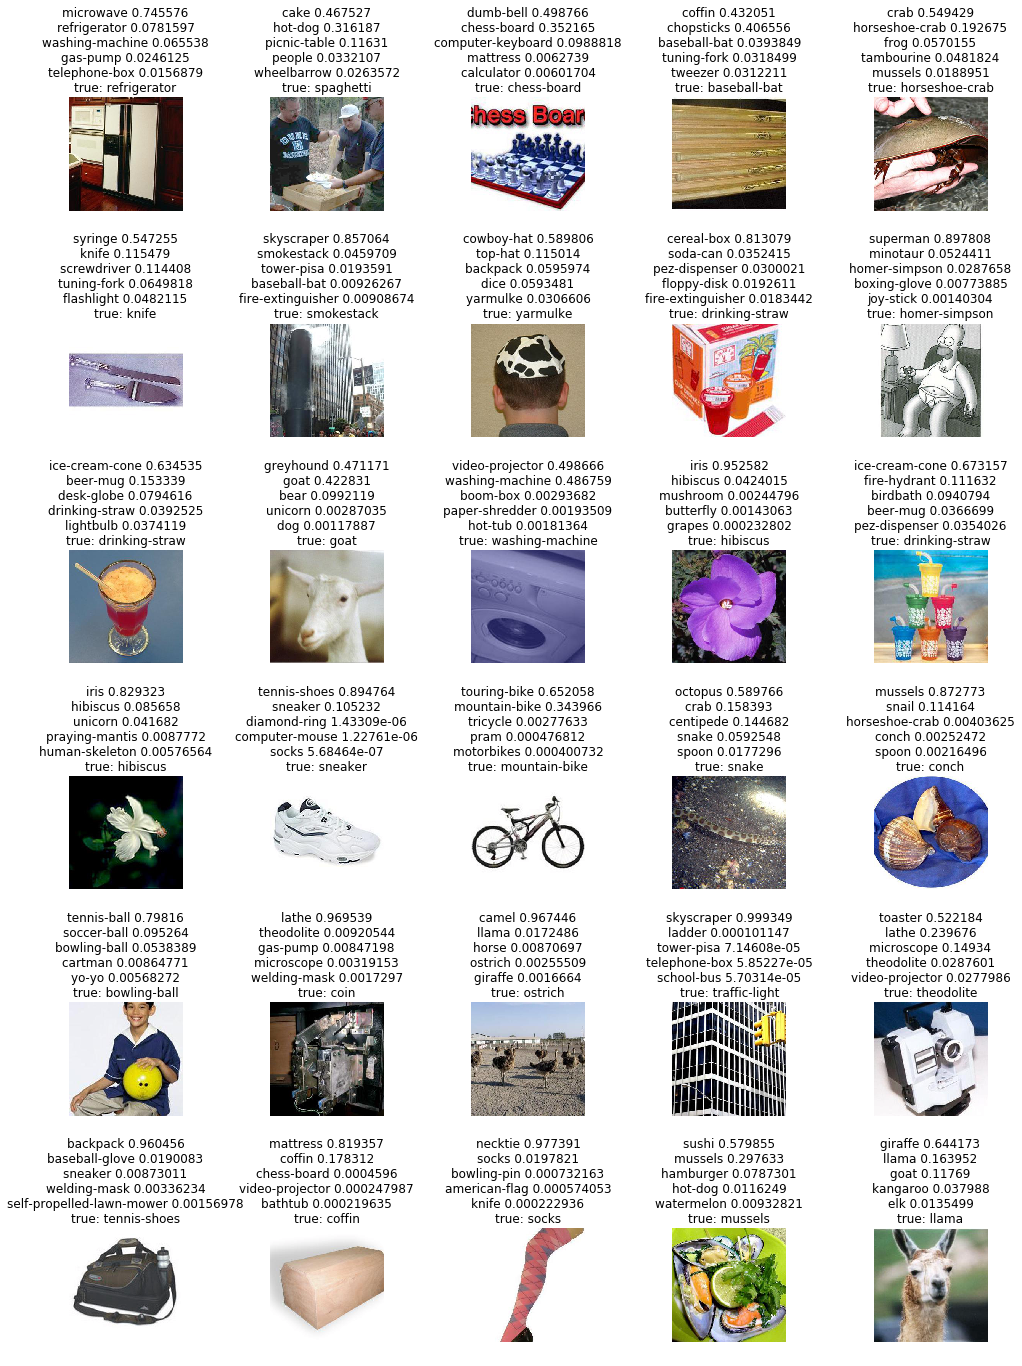

In [34]:
show_errors(
    erroneous_samples[~low_entropy], 
    erroneous_predictions[~low_entropy], 
    erroneous_targets[~low_entropy], 
    decode
)

# Save

In [35]:
model.cpu();
torch.save(model.state_dict(), 'resnet18.pytorch_state')